# Ⅰ.Introduction
PaddlePaddle is a full-featured end-to-end open source deep learning platform in China. It integrates deep learning training and prediction frameworks, model libraries, tool components, and service platforms. It has both flexible and efficient development mechanisms and industrial-grade application effects. Models, ultra-large-scale parallel deep learning capabilities, integrated design of inference engines, and systematic service support are committed to making the innovation and application of deep learning technology easier.

### Advantage

Starting from the paddlepaddle core framework Padlde Fluid v1.5, paddlepaddle provides users with both dynamic graph and static graph mechanisms.

The static graph is to define the network structure first and then run it. Analyzing the defined graph structure can make the running speed faster and occupy less video memory. It has a very big advantage in business deployment and online, providing users with AI applications. Efficient support. In the dynamic graph mode, all operations can obtain the execution results immediately without having to wait until the execution stage to obtain the results, which makes it easier to debug the model, and at the same time reduces a lot of code used to build Executor, making it easier to write and debug the network process becomes more convenient. Users can use the more convenient dynamic graph mode for debugging and training, and then convert the trained model into a static graph structure for quick online deployment.

Based on Baidu's years of experience in industrial applications and the practice of artificial intelligence solutions from Baidu's ecological partners, paddlepaddle provides users with 70+ selected official algorithm models that have been verified by real business scenarios and have the best application effects, covering vision, NLP, voice and Recommendation and other AI core technology fields.

Paddlepaddle supports ultra-large-scale deep learning parallel training for both dense and sparse parameter scenarios, and supports efficient parallel training of hundreds of billions of parameters and hundreds of nodes. It is also the first deep learning platform to provide such a powerful deep learning parallel technology. Paddlepaddle provides a cost-effective multi-machine CPU parameter server solution. Based on the data verification of real recommendation scenarios, it can effectively solve the problems of ultra-large-scale recommendation systems, ultra-large-scale data, self-expanding massive features, and high-frequency model iterations.

Paddlepaddle provides a free GPU and comes with a mobile inference deployment engine.

# Ⅱ.Learn to use paddlepaddle
### install paddlepaddle

In [11]:
# use command: pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple
# or use command : pip install -U paddlepaddle

### import paddlepaddle

In [1]:
import paddle
import paddle.fluid as fluid

### The following are a few examples of using paddle to operate tensora
#### 1·Use Fluid to create a 1D array of 5 elements where each element is 1

In [2]:
#This API turn ON static graph mode. You can turn ON static graph mode by disable_static .
paddle.enable_static()
# Define the array dimension and data type, you can modify the shape parameter to define an array of any size
data = fluid.layers.ones(shape=[5], dtype='int64')
# perform calculations on the CPU
place = fluid.CPUPlace()
# create executor
exe = fluid.Executor(place)
# perform calculations
ones_result = exe.run(fluid.default_main_program(),
                        # get data
                        fetch_list=[data],
                        return_numpy=True)
# output result
print(ones_result[0])

[1 1 1 1 1]


Similar to frameworks such as Tensorflow, paddle also needs to define tensor. For example, fluid.layers.ones will create a tensor with all 1s. Also if we need to see its value, we also need to "run" it. In the paddle, the executor fluid.Executor needs to be used to perform various operations. In addition, when defining the Executor, it is necessary to specify which device to run on. Here, CPUPlace() is used to let the code run on the CPU. Unlike Tensorflow, paddle does not have a session, but has the concept of a program. The operations we define (such as the defined data) are added to the default program (fluid.default_main_program()) by default. When the executor is executed, it is necessary to specify which program to run. Executor.run needs to pass in the program, feed parameters (similar to Tensorflow's run, but no feed is required here), and the output parameter fetch_list. return_numpy tells Executor to return numpy array instead of paddle's tensor, which is convenient for us to print the result (Tensorflow's session.run returns numpy array).

#### 2.Bitwise addition of two arrays using Fluid
Continuing with the example above, we add data to itself:

In [7]:
# Call elementwise_op to add the resulting one-dimensional array bitwise
add = fluid.layers.elementwise_add(data,data)
# Define the place of operation
place = fluid.CPUPlace()
exe = fluid.Executor(place)
# perform calculations
add_result = exe.run(fluid.default_main_program(),
                 fetch_list=[add],
                 return_numpy=True)
# output result
print (add_result[0]) 


[2 2 2 2 2]


#### 3.Convert data types using Fluid
Then we convert the type of int64 to float64:

In [8]:
# Convert one-dimensional integer array to float64 type
cast = fluid.layers.cast(x=data, dtype='float64')
place = fluid.CPUPlace()
exe = fluid.Executor(place)
cast_result = exe.run(fluid.default_main_program(),
                 fetch_list=[cast],
                 return_numpy=True)
print(cast_result[0])

[1. 1. 1. 1. 1.]


### Run a linear regression model

This is a simple linear regression model to help us quickly solve quadratic equations.

In [12]:
import paddle.fluid as fluid
import numpy as np
#generate data
np.random.seed(0)
outputs = np.random.randint(5, size=(10, 4))
res = []
for i in range(10):
        # Suppose the equation is y=4a+6b+7c+2d
        y = 4*outputs[i][0]+6*outputs[i][1]+7*outputs[i][2]+2*outputs[i][3]
        res.append([y])
# define data
train_data=np.array(outputs).astype('float32')
y_true = np.array(res).astype('float32')

#define network
x = fluid.layers.data(name="x",shape=[4],dtype='float32')
y = fluid.layers.data(name="y",shape=[1],dtype='float32')
y_predict = fluid.layers.fc(input=x,size=1,act=None)
#Define the loss function
cost = fluid.layers.square_error_cost(input=y_predict,label=y)
avg_cost = fluid.layers.mean(cost)
#Define the optimization method
sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.05)
sgd_optimizer.minimize(avg_cost)
#parameter initialization
cpu = fluid.CPUPlace()
exe = fluid.Executor(cpu)
exe.run(fluid.default_startup_program())
#Start training, iterate 500 times
for i in range(500):
        outs = exe.run(
                feed={'x':train_data,'y':y_true},
                fetch_list=[y_predict.name,avg_cost.name])
        if i%50==0:
                print ('iter={:.0f},cost={}'.format(i,outs[1][0]))
#Store training results
params_dirname = "result"
fluid.io.save_inference_model(params_dirname, ['x'], [y_predict], exe)

# start forecasting
infer_exe = fluid.Executor(cpu)
inference_scope = fluid.Scope()
# Load the trained model
with fluid.scope_guard(inference_scope):
        [inference_program, feed_target_names,
         fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe)

# Generate test data
test = np.array([[[9],[5],[2],[10]]]).astype('float32')
# make predictions
results = infer_exe.run(inference_program,
                                                feed={"x": test},
                                                fetch_list=fetch_targets)
# given the problem as 【9,5,2,10】 Output the value of y=4*9+6*5+7*2+10*2
print ("9a+5b+2c+10d={}".format(results[0][0]))

iter=0,cost=1191.48291015625
iter=50,cost=0.12038884311914444
iter=100,cost=0.04973287135362625
iter=150,cost=0.020606473088264465
iter=200,cost=0.008538012392818928
iter=250,cost=0.0035377354361116886
iter=300,cost=0.0014657495776191354
iter=350,cost=0.0006073766271583736
iter=400,cost=0.0002516549429856241
iter=450,cost=0.00010426654625916854
9a+5b+2c+10d=[99.9464]


The above code is simple linear regression, which has many similarities with Tensorflow. The differences are:

• No need to specify operations at runtime

In Tensorflow, we tell the engine which operations to calculate through session.run, but in paddlepaddle, we only need to tell it which program to execute. Our default operations are added to the program in order, and it will automatically execute the last operation. (sgd_optimizer. minimize(avg_cost)). This operation will first calculate the forward direction, then calculate the gradient backwards, and finally update the parameters.

• save_inference_model (auto crop)

After the training introduction, we need to save the model with the save_inference_model function, we only need to tell it the input and predicted output, it will automatically crop the calculation graph, and only keep the subgraph from input to output.

•fluid.scope_guard

In order to avoid loading the predicted model into the default program, we use fluid.scope_guard to construct a new Scope, and then load the saved model here for prediction. If you don't construct a new scope, although the code can still run, it is easy to confuse the trained model and the predicted model.

### LoD-Tensor
Most deep learning frameworks have the concept of Tensor, but PaddlePaddle has a special LoD-Tensor in addition to ordinary Tensor, which is used to solve variable-length sequences. In other frameworks, we usually use padding to convert variable-length sequences into fixed-length sequences to solve this problem, which will cause our code to need special logic to handle padding. And PaddlePaddle uses Lod-Tensor to systematically solve the problem of becoming.
Most deep learning frameworks use Tensor to represent a mini-batch.

For example, there are 10 pictures in a mini-batch, and the size of each picture is 32x32, then this mini-batch is a Tensor of 10x32x32.

Or in processing NLP tasks, a mini-batch contains N sentences, and each word is represented by a D-dimensional one-hot vector. Assuming that all sentences use the same length L, then this mini-batch can be expressed as Tensor of NxLxD.

In both examples above the sequence elements are of the same size, but in many cases the training data are sequences of variable length. Based on this scenario, the method adopted by most frameworks is to determine a fixed length, and fill the sequence data smaller than this length with 0.

In Fluid, due to the existence of LoD-Tensor, we do not require the sequence data in each mini-batch to have the same length, so you do not need to perform padding operations, and it can also meet the requirements of processing NLP and other tasks with sequence requirements.

Fluid introduces an indexed data structure (LoD) to split tensors into sequences.

#### In order to better understand the concept of LoD, here are a few examples for your reference:
#### 1.A mini-batch composed of sentences
Suppose there are 3 sentences in a mini-batch, and each sentence contains 3, 1 and 2 words respectively. We can use (3+1+2)xD-dimensional Tensor plus some index information to represent this mini-batch:

In [ ]:
3       1   2
| | |   |   | |

In the above representation, each | represents a D-dimensional word vector, and the numbers 3, 1, and 2 constitute a 1-level LoD
#### 2.recursive sequence
Let's look at another 2-level LoD-Tensor example: Suppose there are articles containing 3 sentences, 1 sentence and 2 sentences in a mini-batch, each sentence consists of a different number of words, then this The style of mini-batch can be seen as:

In [ ]:
3            1 2
3   2  4     1 2  3
||| || ||||  | || |||

The LoD information represented is: [[3，1，2]/level=0/，[3，2，4，1，2，3]/level=1/]
#### 3.video mini-batch
In vision tasks, it is often necessary to process videos and images. These elements are high-dimensional objects. Suppose an existing mini-batch contains 3 videos, with 3, 1 and 2 frames respectively, and each frame has the same size. : 640x480, then this mini-batch can be expressed as:

In [ ]:
3      1  2
口口口 口 口口

The size of the bottom tensor is (3+1+2)x640x480, and each port represents a 640x480 image
#### 4.mini-batch of images
In the traditional case, such as a mini-batch with N fixed-size images, LoD-Tensor is expressed as:

In [ ]:
1 1 1 1      1
口口口口 ... 口

In this case, we will not ignore the information because the index value is 1, just treat the LoD-Tensor as an ordinary tensor:

In [ ]:
口口口口 ... 口

#### 5.Model parameters
Model parameters are just plain tensors, and in Fluid they are represented as a 0-level LoD-Tensor.
### Offset representation of LoDTensor
For fast access to basic sequences, Fluid provides a method of offset representation - saving the start and end elements of the sequence instead of saving the length.

In the above example, you can calculate the length of the primitive element:

In [ ]:
3 2 4 1 2 3

Convert it to offset representation:

In [ ]:
0  3  5   9   10  12   15
   =  =   =   =   =    =
   3  2+3 4+5 1+9 2+10 3+12

So we know that the first sentence is from word 0 to word 3 and the second sentence is from word 3 to word 5.

Similarly, the top-level length of the LoD:

In [ ]:
3 1 2

can be converted to offset form: 

In [ ]:
0 3 4   6
  = =   =
  3 3+1 4+2

Therefore, the offset of the LoD-Tensor is expressed as:

In [ ]:
0       3    4      6
0 3 5 9   10   12 15

### Further understanding of LoD-Tensor
A LoD-Tensor can be regarded as a tree structure, the leaves are the basic sequence elements, and the branches are the identification of the basic elements.

The sequence information of LoD-Tensor in Fluid has two expressions: original length and offset. LoD-Tensor is expressed in the form of offset inside Paddle to obtain faster sequence access speed; LoD-Tensor is expressed in the form of original length in python API, which is convenient for users to understand and calculate, and the original length is called: recursive_sequence_lengths .

Take a 2-level LoD-Tensor mentioned above as an example:

In [ ]:
3           1  2
3   2  4    1  2  3
||| || |||| |  || |||

Represents this LoD-Tensor in terms of offsets: [ [0,3,4,6] , [0,3,5,9,10,12,15] ].

Express this Lod-Tensor in raw lengths: recursive_sequence_lengths=[ [3-0 , 4-3 , 6-4] , [3-0 , 5-3 , 9-5 , 10-9 , 12-10 , 15-12 ] ].

Take the text sequence as an example: [3,1,2] can indicate that there are 3 articles in this mini-batch, each article has 3, 1, and 2 sentences respectively, [3,2,4,1,2,3 ] means that each sentence contains 3, 2, 4, 1, 2, 3 words respectively.

recursive_seq_lens is a double-layer nested list, that is, a list of lists. The size of the outermost list indicates the number of nested layers, which is the size of the lod-level; each internal list corresponds to each lod-level , the size of each element.

The following three pieces of code describe how to create a LoD-Tensor, how to convert a LoD-Tensor to a Tensor, and how to convert a Tensor to a LoD-Tensor:

#### 1.Create LoD-Tensor

In [15]:
#create lod-tensor
import paddle.fluid as fluid
import numpy as np

a = fluid.create_lod_tensor(np.array([[1],[1],[1],
                                  [1],[1],
                                  [1],[1],[1],[1],
                                  [1],
                                  [1],[1],
                                  [1],[1],[1]]).astype('int64') ,
                          [[3,1,2] , [3,2,4,1,2,3]],
                          fluid.CPUPlace())

#View the number of nested layers of lod-tensor
print (len(a.recursive_sequence_lengths()))
# output：2

#View the number of the most basic elements
print (sum(a.recursive_sequence_lengths()[-1]))
# output:15 (3+2+4+1+2+3=15)


2
15


#### 2.LoD-Tensor to Tensor

In [18]:
import paddle.fluid as fluid
import numpy as np

# create one LoD-Tensor
a = fluid.create_lod_tensor(np.array([[1.1], [2.2],[3.3],[4.4]]).astype('float32'), 
                    [[1,3]], fluid.CPUPlace())

def LodTensor_to_Tensor(lod_tensor):
  # Get lod information of LoD-Tensor
  lod = lod_tensor.lod()
  # convert to array
  array = np.array(lod_tensor)
  new_array = []
  # Convert to Tensor according to the level information of the original LoD-Tensor
  for i in range(len(lod[0]) - 1):
      new_array.append(array[lod[0][i]:lod[0][i + 1]])
  return new_array

new_array = LodTensor_to_Tensor(a)

# output result
print(new_array)

[array([[1.1]], dtype=float32), array([[2.2],
       [3.3],
       [4.4]], dtype=float32)]


#### 3.Tensor to LoD-Tensor

In [19]:
import paddle.fluid as fluid
import numpy as np

def to_lodtensor(data, place):
  # Store the length of Tensor as LoD information
  seq_lens = [len(seq) for seq in data]
  cur_len = 0
  lod = [cur_len]
  for l in seq_lens:
      cur_len += l
      lod.append(cur_len)
  # Tensor dimensionality reduction to be transformed
  flattened_data = np.concatenate(data, axis=0).astype("int64")
  flattened_data = flattened_data.reshape([len(flattened_data), 1])
  # Add lod information for Tensor data
  res = fluid.LoDTensor()
  res.set(flattened_data, place)
  res.set_lod([lod])
  return res

# new_array is the Tensor converted in the above code
lod_tensor = to_lodtensor(new_array,fluid.CPUPlace())

# Output LoD information
print("The LoD of the result: {}.".format(lod_tensor.lod()))

# Check whether it is consistent with the original Tensor data
print("The array : {}.".format(np.array(lod_tensor)))

The LoD of the result: [[0, 1, 4]].
The array : [[1]
 [2]
 [3]
 [4]].


LoD will make processing sequences easier

### prepare data
There are three steps to preparing data using PaddlePaddle Fluid:

#### Step1: Customize Reader to generate training/prediction data
The generated data type can be Numpy Array or LoDTensor. According to the different data forms returned by Reader, it can be divided into Batch-level Reader and Sample (sample)-level Reader.

A Batch-level Reader returns a Batch of data each time, and a Sample-level Reader returns a single sample of data each time

If your data is at the Sample level, we provide a tool for data preprocessing and batch formation: Python Reader.

#### Step2: Define data layer variables in network configuration

Users need to define data layer variables in the network using fluid.layers.data. When defining data layer variables, you need to specify the name, data type dtype, and dimension shape of the data layer. E.g:

In [5]:
import paddle.fluid as fluid

image = fluid.layers.data(name='image', dtype='float32', shape=[28, 28])
label = fluid.layers.data(name='label', dtype='int64', shape=[1])

It should be noted that the shape here is the dimension of a single sample, and PaddlePaddle Fluid will add -1 to the 0th dimension of the shape, indicating the dimension of batch_size, that is, image.shape in this example is [-1, 28, 28], label.shape is [-1, 1].

If the user does not want the framework to add -1 to the 0th dimension, it can be controlled by the append_batch_size=False parameter, namely:

In [3]:
import paddle.fluid as fluid

image = fluid.layers.data(name='image', dtype='float32', shape=[28, 28], append_batch_size=False)
label = fluid.layers.data(name='label', dtype='int64', shape=[1], append_batch_size=False)

At this point, image.shape is [28, 28] and label.shape is [1].

#### Step3: Send data to the network for training/prediction
Fluid provides two methods, which are the asynchronous PyReader interface method or the synchronous Feed method. The details are as follows:

#### Asynchronous PyReader interface method

Users need to use fluid.io.PyReader to define the PyReader object first, and then set the data source through the decorate method of the PyReader object. When using the PyReader interface, data input and model training/prediction processes are performed asynchronously, which is highly efficient and recommended.

#### Sync feed method

The user constructs the input data by himself, and uses executor.run(feed=…) in fluid.Executor or fluid.ParallelExecutor to pass in the training data. The process of data preparation and model training/prediction is carried out simultaneously, which is inefficient.

The comparison of these two methods of preparing data is as follows:

Contrast item Synchronous   Feed method Asynchronous             PyReader interface method
API                  interface executor.run(feed=…)         fluid.io.PyReader
Data format            Numpy Array or LoDTensor             Numpy Array or LoDTensor
Data Augmentation        Python side is done using other libraries  Python side is done using other libraries
speed                slow                           fast
Recommended Use         Debugging Models                   Industrial Training

### Data Preprocessing Tools
In the model training and prediction phase, the PaddlePaddle program needs to read training or prediction data. To help you write codes for data reading, we provide the following interfaces:

•reader: A sample-level reader, a function used to read data. Data can come from files, networks, random number generators, etc. The function returns a sample data item each time.

•reader creator: A function that takes one or more readers as arguments and returns a new reader.

•reader decorator: A function that takes one or more readers and returns a reader.

•batch reader: A function used to read data. Data can come from files, networks, random number generators, etc. The function returns a batch-sized data item each time.

In addition, a function to convert the reader to a batch reader is provided, and the reader creator and reader decorator are frequently used.

#### Data Reader interface
Data reader does not necessarily require a function to read and traverse data items. It can be any function without parameters that returns an iterable object (i.e. any object that can be used for x in iterable):

In [ ]:
iterable = data_reader()

Iterable objects should produce data in the form of single items or tuples, not a mini-batch of data. The generated data items should be in supported types, such as float32, numpy one-dimensional matrix of int type, list of int type, etc.

The following is an example of implementing a single item data reader creator:

In [ ]:
def reader_creator_random_image(width, height):
    def reader():
        while True:
            yield numpy.random.uniform(-1, 1, size=width*height)
    return reader

The following is an example of implementing a multiple data reader creator:

In [ ]:
def reader_creator_random_image_and_label(width, height, label):
    def reader():
        while True:
            yield numpy.random.uniform(-1, 1, size=width*height), label
    return reader

#### Batch Reader interface

Batch reader can be any function without parameters that returns an iterable object (i.e. any object that can be used for x in iterable). The output of Iterable should be a batch (list) of data items. Each data item in the list is a tuple.

Here is some valid output:

In [ ]:
# Three data items form a mini batch. Each data item has three columns, each column data item is 1.
[(1, 1, 1),
(2, 2, 2),
(3, 3, 3)]

# Three data items form a mini batch. Each data item is a list (single column).
[([1,1,1],),
([2,2,2],),
([3,3,3],)]

Note that each item in the list must be a tuple, the following is an invalid output:

In [ ]:
# Error, [1,1,1] needs to be in a tuple: ([1,1,1],).
# Otherwise, there is ambiguity, whether [1,1,1] means the data [1, 1, 1] as a whole as a single column.
# Or three columns of data, each column is 1.
[[1,1,1],
[2,2,2],
[3,3,3]]

It's easy to convert a reader into a batch reader:

In [ ]:
mnist_train = paddle.dataset.mnist.train()
mnist_train_batch_reader = paddle.batch(mnist_train, 128)

You can also create a custom batch reader directly:

In [ ]:
def custom_batch_reader():
    while True:
        batch = []
        for i in xrange(128):
            # Note that it must be a tuple, so it is written like (data,)
            batch.append((numpy.random.uniform(-1, 1, 28*28),)) 
        yield batch

mnist_random_image_batch_reader = custom_batch_reader

#### use
Here's how we use PaddlePaddle's reader:

Batch reader is a mapping from data item to data layer (data layer), batch_size and total number of passes are passed to paddle.train in the following way:

In [ ]:
# Create two data layers:
image_layer = paddle.layer.data("image", ...)
label_layer = paddle.layer.data("label", ...)

batch_reader = paddle.batch(paddle.dataset.mnist.train(), 128)
# The second parameter tells paddle batch_reader that the first element (0) of the tuple of the sample is image, and the second is label
# 128 is batch_size, 10 is the number of training epochs。
paddle.train(batch_reader, {"image":0, "label":1}, 128, 10, ...)

#### Data Reader decorator
The Data reader decorator accepts one or more reader objects as parameters and returns a new reader object. It is similar to the python decorator, but does not need to write @ syntactically.

We have strict restrictions on the data reader interface (take no parameters and return a single data item), and the data reader can be flexibly used with data reader decorators. Here are some examples:

#### 1.Prefetch data (cache data)

Since reading data takes some time and training cannot be done without data, data prefetching is generally a good approach.

Preread data with paddle.reader.buffered:

In [ ]:
buffered_reader = paddle.reader.buffered(paddle.dataset.mnist.train(), 100)

buffered_reader will try to buffer (prefetch) 100 data items.

#### 2.Composition of multiple Data Readers

For example, if we want to use actual image sources (that is, multiplex the mnist dataset) and random image sources as input to Generative Adversarial Networks.

We can refer to the following:

In [ ]:
def reader_creator_random_image(width, height):
    def reader():
        while True:
            yield numpy.random.uniform(-1, 1, size=width*height)
    return reader

def reader_creator_bool(t):
    def reader():
        while True:
            yield t
    return reader

true_reader = reader_creator_bool(True)
false_reader = reader_creator_bool(False)

reader = paddle.reader.compose(paddle.dataset.mnist.train(), reader_creator_random_image(20, 20),
                true_reader, false_reader)
# Skip 1 because paddle.dataset.mnist.train() generates two items for each data item.

#### 3.random order

Given a randomly sorted buffer of size n, paddle.reader.shuffle returns a data reader that buffers n data items and shuffles them before reading a data item.

Example:

In [ ]:
reader = paddle.reader.shuffle(paddle.dataset.mnist.train(), 512)

### Asynchronous data read
PyReader is used to read asynchronous data. The performance of PyReader is better than synchronous data reading, because PyReader's data reading and model training process are asynchronous, and can cooperate with double_buffer_reader to further improve data reading performance. In addition, double_buffer_reader is responsible for asynchronously completing the conversion from CPU Tensor to GPU Tensor, which improves the data reading efficiency to a certain extent.

#### Create a PyReader object
The way to create a PyReader object is:

In [ ]:
import paddle.fluid as fluid

image = fluid.layers.data(name='image', dtype='float32', shape=[784])
label = fluid.layers.data(name='label', dtype='int64', shape=[1])

ITERABLE = True

py_reader = fluid.io.PyReader(feed_list=[image, label], capacity=64, 
            use_double_buffer=True, iterable=ITERABLE)

•feed_list is a list of data layer variables that need to be input;

• capacity is the buffer size of the PyReader object;

• use_double_buffer is True by default, which means to use double_buffer_reader. It is recommended to enable it to increase the data reading speed;

• iterable defaults to True, indicating that the PyReader object is For-Range iterable. When iterable=True, PyReader is decoupled from Program, and defining the PyReader object will not change Program; when iterable=False, PyReader will insert ops related to data reading into Program.

It should be noted that: Program.clone() cannot realize the copying of PyReader objects. If you want to create multiple different PyReader objects (for example, you need to create two different PyReader objects during the training and prediction stages), you need to redefine the two PyReader objects. If you need to share model parameters in the training phase and testing phase, you can use fluid.unique_name.guard() to achieve this. Note: Paddle uses variable names to distinguish different variables, and the variable names are automatically generated according to the counter in the unique_name module, and the count value increases by 1 for each variable name generated. The role of fluid.unique_name.guard() is to reset the counter in the unique_name module to ensure that the variable names of the corresponding variables are the same when calling fluid.unique_name.guard() multiple times to configure the network, so as to realize parameter sharing.

#### Set the data source of the PyReader object
A PyReader object sets its data source via the decorate_sample_generator() , decorate_sample_list_generator and decorate_batch_generator() methods. These three methods all receive the Python generator generator as a parameter, the difference is:

•decorate_sample_generator() requires the data format returned by the generator to be [img_1, label_1], where img_1 and label_1 are Numpy Array type data of a single sample.

•decorate_sample_list_generator() requires the data format returned by the generator to be [(img_1, label_1), (img_2, label_2), …, (img_n, label_n)], where img_i and label_i are the Numpy Array type data of each sample, and n is batch size.

•decorate_batch_generator() requires the data format of the data returned by the generator to be [batched_imgs, batched_labels], where batched_imgs and batched_labels are batch-level Numpy Array or LoDTensor type data.

When PyReader's iterable=True (default), you must pass the places parameter to these three methods to specify whether to convert the read data into CPU Tensor or GPU Tensor. When PyReader's iterable=False, there is no need to pass the places parameter.

For example, suppose we have two readers, where fake_sample_reader returns a sample of data each time, and fake_batch_reader returns a batch of data each time.

In [8]:
import paddle.fluid as fluid
import numpy as np

# sample-level reader
def fake_sample_reader():
    for _ in range(100):
        sample_image = np.random.random(size=(784, )).astype('float32')
        sample_label = np.random.random_integers(size=(1, ), low=0, high=9).astype('int64')
        yield sample_image, sample_label

# batch-level reader
def fake_batch_reader():
    batch_size = 32
    for _ in range(100):
        batch_image = np.random.random(size=(batch_size, 784)).astype('float32')
        batch_label = np.random.random_integers(size=(batch_size, 1), low=0, high=9).astype('int64')
        yield batch_image, batch_label

image1 = fluid.layers.data(name='image1', dtype='float32', shape=[784])
label1 = fluid.layers.data(name='label1', dtype='int64', shape=[1])

image2 = fluid.layers.data(name='image2', dtype='float32', shape=[784])
label2 = fluid.layers.data(name='label2', dtype='int64', shape=[1])

image3 = fluid.layers.data(name='image3', dtype='float32', shape=[784])
label3 = fluid.layers.data(name='label3', dtype='int64', shape=[1])

The corresponding PyReader settings are as follows

In [10]:
import paddle
import paddle.fluid as fluid

ITERABLE = True
USE_CUDA = False
USE_DATA_PARALLEL = True

if ITERABLE:
    # If PyReader is iterable, the places parameter must be set
    if USE_DATA_PARALLEL:
        # For multi-GPU card training, take all CUDAPlace
        # If multi-CPU core training is performed, multiple CPUPlaces are taken. In this example, 8 CPUPlaces are taken
        places = fluid.cuda_places() if USE_CUDA else fluid.cpu_places(8)
    else:
        # If training with a single GPU card, take a single CUDAPlace, in this example 0 represents GPU card number 0
        # For single CPU core training, take a single CPUPlace, in this example 1 represents 1 CPUPlace
        places = fluid.cuda_places(0) if USE_CUDA else fluid.cpu_places(1)
else:
    # If PyReader is not iterable, you don't need to set the places parameter
    places = None

# Use the sample-level reader as the data source of PyReader
py_reader1 = fluid.io.PyReader(feed_list=[image1, label1], capacity=10, iterable=ITERABLE)
py_reader1.decorate_sample_generator(fake_sample_reader, batch_size=32, places=places)

# Use sample-level reader + paddle.batch to set the data source of PyReader
py_reader2 = fluid.io.PyReader(feed_list=[image2, label2], capacity=10, iterable=ITERABLE)
sample_list_reader = paddle.batch(fake_sample_reader, batch_size=32)
sample_list_reader = paddle.reader.shuffle(sample_list_reader, buf_size=64) # 还可以进行适当的shuffle
py_reader2.decorate_sample_list_generator(sample_list_reader, places=places)

# Use batch-level reader as the data source of PyReader
py_reader3 = fluid.io.PyReader(feed_list=[image3, label3], capacity=10, iterable=ITERABLE)
py_reader3.decorate_batch_generator(fake_batch_reader, places=places)

#### What we need to pay attention to is：Depending on whether the PyReader object is iterable, choose different ways to run the network.
If iterable=True, the PyReader object is a Python generator that can be directly for-range iterated. The result returned by for-range is passed to the executor through the feed parameter of exe.run.

In [ ]:
def run_iterable(program, exe, loss, py_reader):
    for data in py_reader():
        loss_value = exe.run(program=program, feed=data, fetch_list=[loss])
        print('loss is {}'.format(loss_value))

for epoch_id in six.moves.range(10):
    run_iterable(train_prog, exe, train_loss, train_reader)
    run_iterable(test_prog, exe, test_loss, test_reader)

If iterable=False, you need to call the start() method to start the PyReader object before the start of each epoch; and at the end of each epoch, exe.run will throw a fluid.core.EOFException exception, and call reset after catching the exception The () method resets the state of the PyReader object in order to start the next round of epoch. When iterable=False, there is no need to pass feed parameters to exe.run. The specific way is:

In [ ]:
def run_non_iterable(program, exe, loss, py_reader):
    py_reader.start()
    try:
        while True:
            loss_value = exe.run(program=program, fetch_list=[loss])
            print('loss is {}'.format(loss_value))
    except fluid.core.EOFException:
        print('End of epoch')
        py_reader.reset()

for epoch_id in six.moves.range(10):
    run_non_iterable(train_prog, exe, train_loss, train_reader)
    run_non_iterable(test_prog, exe, test_loss, test_reader)

### synchronous data read
PaddlePaddle Fluid supports using fluid.layers.data() to configure the data layer; then use Numpy Array or directly use Python to create C++ fluid.LoDTensor, and pass it to fluid.Executor or fluid.ParallelExecutor through Executor.run(feed=…).

#### Data layer configuration
The data layers required in the neural network can be configured through fluid.layers.data(). The specific method is:

In [ ]:
import paddle.fluid as fluid

image = fluid.layers.data(name="image", shape=[3, 224, 224])
label = fluid.layers.data(name="label", shape=[1], dtype="int64")

# use image/label as layer input
prediction = fluid.layers.fc(input=image, size=1000, act="softmax")
loss = fluid.layers.cross_entropy(input=prediction, label=label)
...

In the above code, image and label are two input data layers created by fluid.layers.data. Where image is floating-point data of [3, 224, 224] dimension; label is integer data of [1] dimension. The things to note here are:

By default, Fluid uses -1 to indicate the batch size dimension, and by default, -1 is added to the first dimension of the shape. So in the above code, we can accept passing a numpy array of [32, 3, 224, 224] to image. If you want to customize the position of the batch size dimension, please set fluid.layers.data(append_batch_size=False). Please refer to the custom BatchSize dimension in advanced usage.

The data type used for class labels in Fluid is int64, and the labels start from 0. For available data types, please refer to the data types currently supported by Fluid below.

#### Pass training data to executor
Both Executor.run and ParallelExecutor.run accept a feed parameter. This parameter is a Python dictionary. Its key is the name of the data layer, such as image in the code above. Its value is the corresponding numpy array.

E.g:

In [ ]:
exe = fluid.Executor(fluid.CPUPlace())
# init Program
exe.run(fluid.default_startup_program())
exe.run(feed={
   "image": numpy.random.random(size=(32, 3, 224, 224)).astype('float32'),
   "label": numpy.random.random(size=(32, 1)).astype('int64')
})

### How to pass in sequence data

Sequence data is a special data type supported by PaddlePaddle Fluid, and LoDTensor can be used as an input data type. It needs the user: 1. Pass in all the data that needs to be trained in a mini-batch; 2. The length information of each sequence. Users can use fluid.create_lod_tensor to create LoDTensor.

When passing in sequence information, you need to set the sequence nesting depth, lod_level. For example, if the training data is a sentence composed of vocabulary, lod_level=1; if the training data is a sentence composed of vocabulary first, and then a paragraph, then lod_level=2.

E.g:

In [ ]:
sentence = fluid.layers.data(name="sentence", dtype="int64", shape=[1], lod_level=1)

...

exe.run(feed={
  "sentence": create_lod_tensor(
    data=numpy.array([1, 3, 4, 5, 3, 6, 8], dtype='int64').reshape(-1, 1),
    recursive_seq_lens=[[4, 1, 2]],
    place=fluid.CPUPlace()
  )
})

The training data sentence contains three samples whose lengths are 4, 1, and 2, respectively. They are data[0:4], data[4:5] and data[5:7] respectively.

### The data types currently supported by PaddlePaddle Fluid include:

• float16: some operations support

• float32: primary real number type

•float64: Secondary real number type, supports most operations

• int32: minor tag type

• int64: main tag type

•uint64: Secondary tag type

•bool: control flow data type

• int16: minor label type

• uint8: input data type, can be used for image pixels

### Modeling with PaddlePaddle

After clarifying the input data format, model structure, loss function, and optimization algorithm from the logical level, it is necessary to use the API and operators provided by PaddlePaddle to implement the model logic. A typical model mainly includes four parts, namely: input data format definition, model forward calculation logic, loss function and optimization algorithm.

#### data layer
PaddlePaddle provides the fluid.layers.data() operator to describe the format of the input data.

The output of the fluid.layers.data() operator is a Variable. The actual type of this Variable is Tensor. Tensor has powerful representation capabilities and can represent multidimensional data. In order to accurately describe the data structure, it is usually necessary to specify the data shape and the numeric type type. Where shape is an integer vector, and type can be a string type. For the currently supported data types, refer to Data Types Currently Supported by Fluid . Model training generally uses batches to read data, and the size of batches may not be fixed during the training process. The data operator will infer the batch size based on the actual data, so you don’t need to care about the batch size when providing the shape here, you only need to care about the shape of a sample. For more advanced usage, please refer to Customizing the BatchSize dimension. From the above, x is a 13-dimensional real number vector, and y is a real number. You can use the following code to define the data layer:

In [ ]:
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
y = fluid.layers.data(name='y', shape=[1], dtype='float32')

The data used in this model is relatively simple. In fact, the data operator can also describe variable-length, nested sequence data. It is also possible to open files for training with open_files. For more detailed documentation, please refer to Preparing Data.

#### Forward Calculation Logic
The most important part of implementing a model is to implement calculation logic, and PaddlePaddle provides a wealth of operators. The encapsulation granularity of these operators is different, usually corresponding to one or a group of transformation logic. The operator output is the result of the transformation performed on the input data. Users can flexibly use operators to complete complex model logic. For example, more convolution operators are used in image-related tasks, and operators such as LSTM/GRU are used in sequence tasks. Complex models usually combine multiple operators to complete complex transformations. PaddlePaddle provides a very natural way to combine operators. Generally, the following methods can be used:1

In [ ]:
op_1_out = fluid.layers.op_1(input=op_1_in, ...)
op_2_out = fluid.layers.op_2(input=op_1_out, ...)
...

Among them, op_1 and op_2 represent the operator type, which can be fc to perform linear transformation (full connection), or conv to perform convolution transformation, etc. The calculation sequence and data flow direction of operators are defined by the connection of the input and output of operators. In the above example, the output of op_1 is the input of op_2, then when the calculation is performed, op_1 will be calculated first, and then op_2 will be calculated. More complex models may need to use control flow operators to dynamically execute according to the input data. For this case, PaddlePaddle provides IfElseOp and WhileOp, etc. Operator documentation can refer to fluid.layers. for example, we use an fc operator:

In [ ]:
y_predict = fluid.layers.fc(input=x, size=1, act=None)

#### loss function
The loss function corresponds to the solution objective, and we can solve the model by minimizing the loss. The loss function used by most models, the output is a real value. However, the loss operator provided by PaddlePaddle is generally calculated for one sample. When a batch of data is input, the output of the loss operator has multiple values, and each value corresponds to the loss of a sample. Therefore, operators such as mean are usually used behind the loss operator to reduce the loss. The model will get a loss value after one forward iteration, and PaddlePaddle will automatically execute the chain derivation rule to calculate the gradient value corresponding to each parameter and variable in the model. For example, using the mean square error loss:

In [ ]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y)
avg_cost = fluid.layers.mean(cost)

#### Optimization
After the loss function is determined, the loss value can be obtained through forward calculation, and then the gradient value of the parameter can be obtained through the chain derivation rule. After obtaining the gradient value, the parameters need to be updated. The simplest algorithm is the stochastic gradient descent method: w = w − η ⋅ g . However, there are some problems in the ordinary stochastic gradient descent algorithm: such as unstable convergence and so on. In order to improve the training speed and effect of the model, the academic community has proposed many optimization algorithms, including: Momentum, RMSProp, Adam, etc. These optimization algorithms use different strategies to update model parameters, and generally the optimization algorithm can be selected for specific tasks and specific models. Regardless of the optimization algorithm used, the learning rate is generally an important hyperparameter that needs to be specified and needs to be carefully adjusted through experiments. For example, the stochastic gradient descent algorithm:

In [ ]:
sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.001)

For more optimization operators, please refer to fluid.optimizer().

# Ⅲ.Example
The process of building a neural network using the Paddle framework is as follows:

• import paddle library;

• Define a class inherited from paddle.nn.Layer, and initialize the sublayer (or parameters) of the neural network in the __init__() method;

• Override the forward() method, and implement the neural network calculation process in this method.
The essence of initializing the neural network sublayer in the __init__() method is to initialize the parameters of the neural network, and different sublayers are essentially the encapsulation of different partial parameter initialization and forward calculation processes. The following two network construction methods are equivalent:

In [27]:
import paddle
paddle.disable_static()

# Construction method 1: Use the built-in packaged sub-layer of the flying paddle framework
class LinearNet1(paddle.nn.Layer):
 def __init__(self):
     super(LinearNet1, self).__init__()

     # The Linear layer packaged with the flying paddle framework
     self.linear = paddle.nn.Linear(in_features=3, out_features=2)

 def forward(self, x):
     return self.linear(x)


# Construction Method 2: Custom Neural Network Parameters
class LinearNet2(paddle.nn.Layer):
 def __init__(self):
     super(LinearNet2, self).__init__()

     # Custom Neural Network Parameters
     w = self.create_parameter(shape=[3, 2])
     b = self.create_parameter(shape=[2], is_bias=True)
     self.add_parameter('w', w)
     self.add_parameter('b', b)

 def forward(self, x):
     x = paddle.matmul(x, self.w)
     x = x + self.b
     return x


if __name__ == "__main__":
 model1 = LinearNet1()
 model2 = LinearNet2()

 print('LinearNet1模型结构信息：')
 paddle.summary(model1, input_size=(None, 3))
 print('LinearNet2模型结构信息：')
 paddle.summary(model2, input_size=(None, 3))

LinearNet1模型结构信息：
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-1           [[1, 3]]              [1, 2]               8       
Total params: 8
Trainable params: 8
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------------------------------

LinearNet2模型结构信息：
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
 LinearNet2-1         [[1, 3]]              [1, 2]               8       
Total params: 8
Trainable params: 8
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB

The process of training a neural network using the flying paddle framework is as follows:

1. Instantiate the model object model;

2. Use model.eval() to change the model to eval mode;

3. Define the optimizer opt and specify the optimization parameters;

4. Input data in the loop, execute the forward calculation process of the model, and obtain the forward output result;

5. Calculate the loss loss of the forward output result and the label of the data;

6. Use loss.backward() for backward propagation to calculate the gradient of loss with respect to model parameters;

7. Use opt.step() to update the model parameters once;

8. Use opt.clear_grad() to clear the model parameter gradient;

9. Go back to 4 and continue to optimize the model parameters.

The sample code is as follows:

In [29]:
def train(epochs: int = 5):
    """
    Example of training process

    :param epochs: Number of traversals over the dataset
    :return:
    """
    # Instantiate the model object
    model = LinearNet1()
    # Change to eval mode
    model.eval()

    # define optimizer
    opt = paddle.optimizer.SGD(learning_rate=1e-2, parameters=model.parameters())

    for epoch in range(epochs):
        # Generate random inputs and labels
        fake_inputs = paddle.randn(shape=(10, 3), dtype='float32')
        fake_labels = paddle.randn(shape=(10, 2), dtype='float32')

        # forward calculation
        output = model(fake_inputs)
        # calculate loss
        loss = paddle.nn.functional.mse_loss(output, fake_labels)

        print(f'Epoch:{epoch}, Loss:{loss.numpy()}')

        # backpropagation
        loss.backward()
        # parameter update
        opt.step()
        # clear gradient
        opt.clear_grad()

train()

Epoch:0, Loss:[5.5721216]
Epoch:1, Loss:[1.5222716]
Epoch:2, Loss:[3.1972852]
Epoch:3, Loss:[4.034009]
Epoch:4, Loss:[3.7167325]


Paddle framework provides a very simple and easy-to-use API to save or load model parameters during model training and application. details as follows:

Save model parameters:

paddle. save(model. state_dict(), 'save_path/model. pdparams')

Load model parameters:

state_dict = paddle.load('save_path/model.pdparams')
model.set_state_dict(state_dict)

#### The most classic case, using the MNIST dataset to train and test the LeNet model

Cache file C:\Users\liuchen\.cache\paddle\dataset\mnist\t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download


item 403/403 [============================>.] - ETA: 0s - 29ms/item


Download finished
Cache file C:\Users\liuchen\.cache\paddle\dataset\mnist\t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download


item 2/2 [===========================>..] - ETA: 0s - 2ms/item


Download finished


The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5
step 938/938 [==============================] - loss: 0.0165 - acc: 0.9428 - 26ms/step          
Epoch 2/5
step 938/938 [==============================] - loss: 0.0131 - acc: 0.9783 - 27ms/step          
Epoch 3/5
step 938/938 [==============================] - loss: 0.0129 - acc: 0.9834 - 28ms/step          
Epoch 4/5
step 938/938 [==============================] - loss: 0.0039 - acc: 0.9857 - 30ms/step          
Epoch 5/5
step 938/938 [==============================] - loss: 0.0063 - acc: 0.9876 - 27ms/step          
Eval begin...
step 157/157 [==============================] - loss: 2.7192e-04 - acc: 0.9821 - 12ms/step      
Eval samples: 10000
true label: 7, pred label: 7


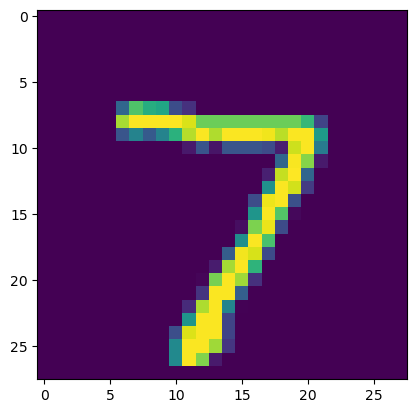

In [30]:
import paddle
import numpy as np
from paddle.vision.transforms import Normalize

transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# Download the dataset and initialize the DataSet
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

# Model network and initialize the network
lenet = paddle.vision.models.LeNet(num_classes=10)
model = paddle.Model(lenet)

# Configuration preparation for model training, preparation of loss functions, optimizers and evaluation metrics
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()), 
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy())

# model training
model.fit(train_dataset, epochs=5, batch_size=64, verbose=1)
# model evaluation
model.evaluate(test_dataset, batch_size=64, verbose=1)

# save model
model.save('./output/mnist')
# load model
model.load('output/mnist')

# Take an image from the test set
img, label = test_dataset[0]
# Change the image shape from 1*28*28 to 1*1*28*28, add a batch dimension to match the model input format requirements
img_batch = np.expand_dims(img.astype('float32'), axis=0)

# Execute reasoning and print the results, here predict_batch returns a list, take out the data in it to get the prediction result
out = model.predict_batch(img_batch)[0]
pred_label = out.argmax()
print('true label: {}, pred label: {}'.format(label[0], pred_label))
# visual image
from matplotlib import pyplot as plt
plt.imshow(img[0])


The above deep learning tasks are completed through several simple APIs of paddle. The summary of the whole process and the key APIs used are shown in the figure below.

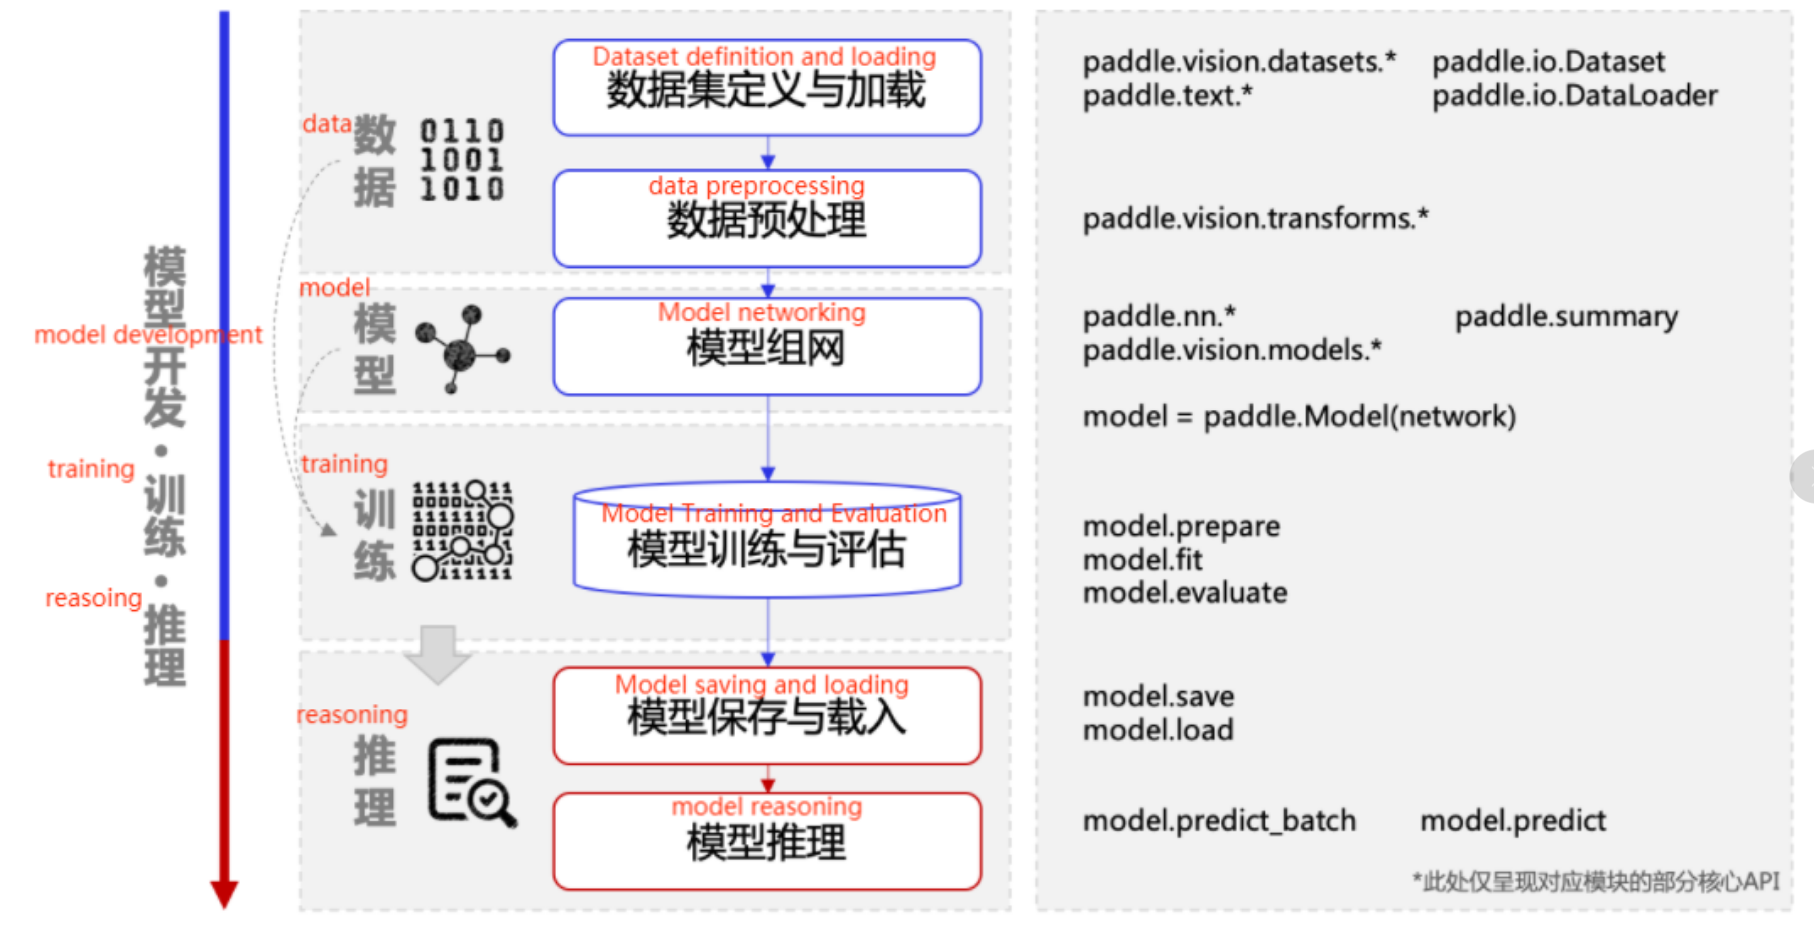

# Ⅳ.References
Because paddlepaddle is a very huge framework, the above examples are only a small part of it. Here are some reference materials for everyone to learn:

user's guidance:https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/beginner/index_cn.html

API:https://www.bookstack.cn/read/paddlepaddle-v1.5/576d2d1ab917d60c.md

Emotion recognition project based on PaddlePaddle:https://aistudio.baidu.com/aistudio/projectdetail/2342217?contributionType=1